In [2]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
remote: Counting objects: 6, done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0)
Unpacking objects: 100% (6/6), done.


In [3]:
!dir german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import pickle
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pandas as pd
import random

Using TensorFlow backend.


In [0]:
np.random.seed(0)

In [0]:
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)

In [7]:
print(type(train_data))

<class 'dict'>


In [0]:
x_train, y_train = train_data['features'], train_data['labels']
x_val, y_val = val_data['features'], val_data['labels']
x_test, y_test = test_data['features'], test_data['labels']

In [9]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [10]:
y_test

array([16,  1, 38, ...,  6,  7, 10], dtype=uint8)

In [0]:
assert(x_train.shape[0] == y_train.shape[0]), "Number of images is not equal to no of labels"
assert(x_val.shape[0] == y_val.shape[0]), "Number of images is not equal to no of labels"
assert(x_test.shape[0] == y_test.shape[0]), "Number of images is not equal to no of labels"
assert(x_train.shape[1:] == (32,32,3)), "Shape of training data is not 32*32*3"
assert(x_val.shape[1:] == (32,32,3)), "Shape of training data is not 32*32*3"
assert(x_test.shape[1:] == (32,32,3)), "Shape of training data is not 32*32*3"

In [12]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
data

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


In [0]:
num_of_samples = []
 
cols = 5
num_classes = 43

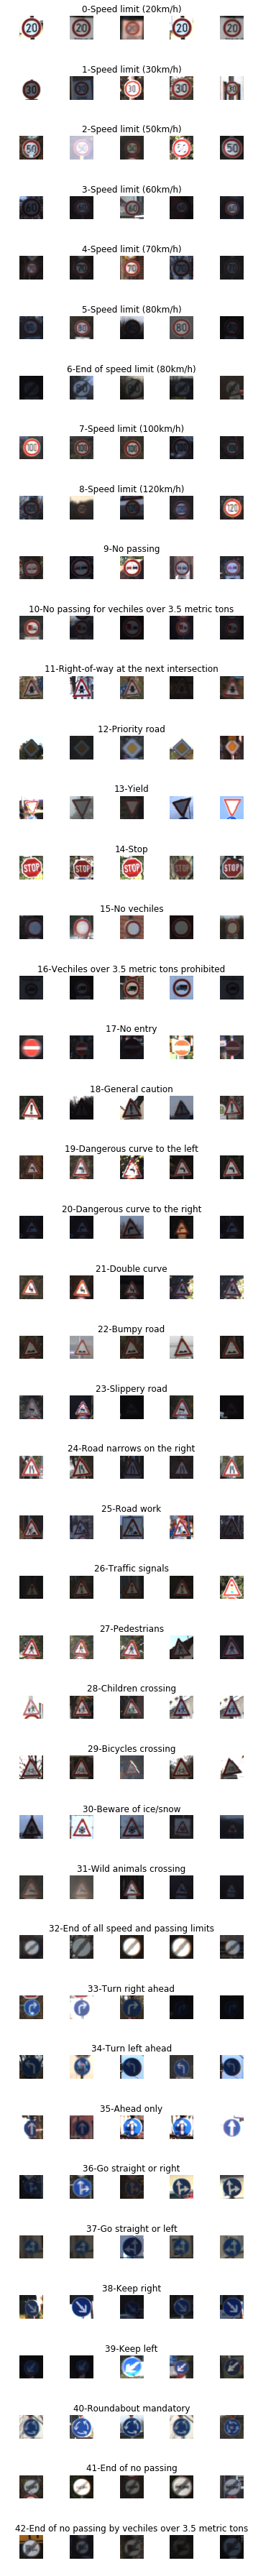

In [14]:
fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 50))
fig.tight_layout()
for i in range(cols):
    for j,row in data.iterrows():
        x_selected = x_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0,len(x_selected)- 1),:, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "-" + row['SignName'])
            num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'no of images')

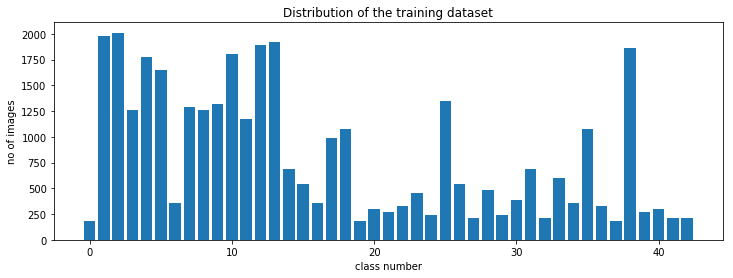

In [15]:
print(num_of_samples)
plt.figure(figsize=(12,4))
plt.bar(range(0,num_classes),num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("class number")
plt.ylabel("no of images")

(32, 32, 3)
ClassId                       36
SignName    Go straight or right
Name: 36, dtype: object


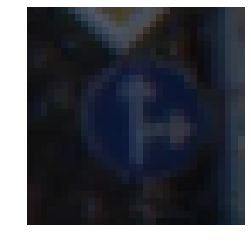

In [16]:
import cv2 
plt.imshow(x_train[1000])
plt.axis("off")
print(x_train[1000].shape)
print(data.iloc[y_train[1000]])

In [0]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

(32, 32)


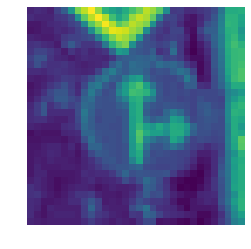

In [18]:
img = grayscale(x_train[1000])

plt.imshow(img)
plt.axis("off")
print(img.shape)

(32, 32)


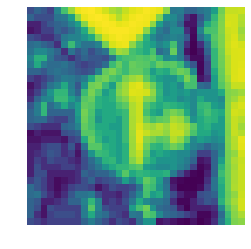

In [19]:
#to have similar lighting effect in background
def equalize(img):
    img = cv2.equalizeHist(img)
    return img# only grayscale images

img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

In [0]:
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255 #normalizing the input
    return img

In [0]:
x_train = np.array(list(map(preprocessing, x_train)))
x_val= np.array(list(map(preprocessing, x_val)))
x_test = np.array(list(map(preprocessing, x_test)))

(34799, 32, 32)


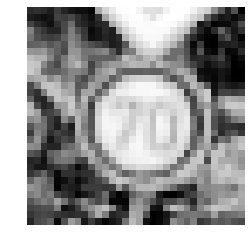

In [22]:
plt.imshow(x_train[random.randint(0,len(x_train)-1)],cmap = 'gray')
plt.axis("off")
print(x_train.shape)

In [0]:
x_train = x_train.reshape(x_train.shape[0], 32, 32, 1)
x_val = x_val.reshape(x_val.shape[0], 32, 32, 1)
x_test = x_test.reshape(x_test.shape[0], 32, 32, 1)

In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen  = ImageDataGenerator(width_shift_range = 0.1,
                             height_shift_range = 0.1,
                             zoom_range = 0.2,
                             shear_range = 0.1,
                             rotation_range = 10)
datagen.fit(x_train)

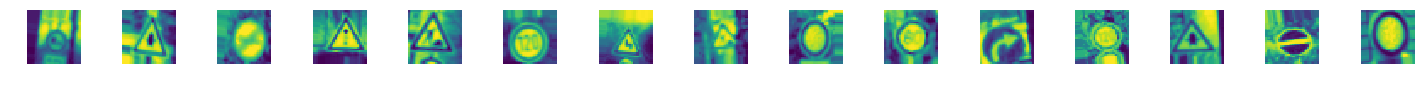

In [25]:
batches = datagen.flow(x_train, y_train, batch_size = 20)
x_batch, y_batch = next(batches)
fig, axs = plt.subplots(1, 15, figsize = (20,5))
fig.tight_layout()
for i in range(15):
  axs[i].imshow(x_batch[i].reshape(32,32))
  axs[i].axis("off")

In [26]:
x_train.shape

(34799, 32, 32, 1)

In [0]:
y_train = to_categorical(y_train,43)
y_test = to_categorical(y_test,43)
y_val = to_categorical(y_val,43)

In [0]:
def model():
    model = Sequential()
    model.add(Conv2D(60, (5,5), input_shape = (32,32,1), activation = 'relu')) #no need to ad padding as our image is centralized
    model.add(Conv2D(60, (5,5), activation = 'relu')) #no need to ad padding as our image is centralized
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(30, (3,3), activation = 'relu'))
    model.add(Conv2D(30, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
#     model.add(Dropout(0.5))

    
    model.add(Flatten()) # to convert 6*6*15 to 1D array
    model.add(Dense(500, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation = 'softmax'))
    
    model.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model


In [29]:
model = model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_2 (MaxP

In [30]:
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size = 30), steps_per_epoch = 2000, epochs = 30, validation_data = (x_val,y_val), shuffle = 1)





Instructions for updating:
Use tf.cast instead.
Epoch 1/30
2000/2000 [==============================] - 29s 14ms/step - loss: 1.1648 - acc: 0.6622 - val_loss: 0.1236 - val_acc: 0.9669
Epoch 2/30
2000/2000 [==============================] - 23s 11ms/step - loss: 0.3101 - acc: 0.9025 - val_loss: 0.0837 - val_acc: 0.9787
Epoch 3/30
2000/2000 [==============================] - 24s 12ms/step - loss: 0.2130 - acc: 0.9350 - val_loss: 0.0697 - val_acc: 0.9789
Epoch 4/30
2000/2000 [==============================] - 23s 12ms/step - loss: 0.1664 - acc: 0.9476 - val_loss: 0.0505 - val_acc: 0.9873
Epoch 5/30
2000/2000 [==============================] - 23s 11ms/step - loss: 0.1440 - acc: 0.9556 - val_loss: 0.0461 - val_acc: 0.9871
Epoch 6/30
2000/2000 [==============================] - 22s 11ms/step - loss: 0.1225 - acc: 0.9627 - val_loss: 0.0405 - val_acc: 0.9882
Epoch 7/30
2000/2000 [==============================] - 22s 11ms/step - loss: 0.1139 - acc: 0.9650 - val_loss: 0.0329 - val_acc: 0.9893


In [0]:
model.save('trained_model_test_final.h5')

In [0]:
from google.colab import files
files.download('trained_model_test_final.h5')

Text(0.5, 0, 'epoch')

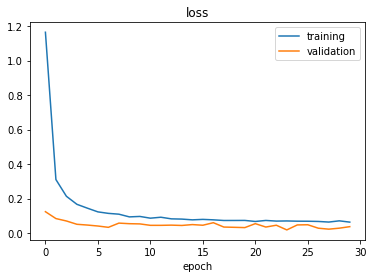

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

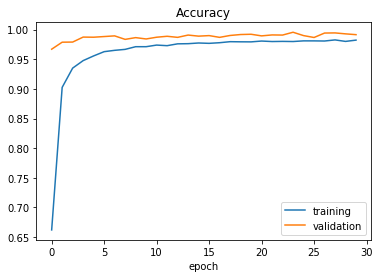

In [34]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [35]:
score = model.evaluate(x_test, y_test, verbose = 0)

print("Test score:", score[0])# loss 
print("Test Accuracy:", score[1])


Test score: 0.1711222708273344
Test Accuracy: 0.9693586698526063


In [0]:
# since from the graph, we can see that our validation data is high in terms of loss and low in terms of accuracy, that means that we are overfitting the training data.
# an also accuracy is too low.



In [0]:
########################################

In [0]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import keras
import pickle
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pandas as pd
import random

In [0]:
from keras.models import load_model
model = load_model('trained_model_best.h5')


In [0]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def equalize(img):
    img = cv2.equalizeHist(img)
    return img#

def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255 #normalizing the input
    return img


In [0]:
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)


In [0]:
x_test, y_test = test_data['features'], test_data['labels']
x_test = np.array(list(map(preprocessing, x_test)))

In [0]:
x_test = x_test.reshape(x_test.shape[0], 32, 32, 1)

In [0]:
from sklearn.metrics import confusion_matrix
y_pr=model.predict_classes(x_test)


In [0]:
data = pd.read_csv('german-traffic-signs/signnames.csv')

In [0]:
data_np=np.array(data["SignName"])

In [0]:
y_test_label=[]
y_pred_label=[]
# data_np[1]

In [50]:
y_test

array([16,  1, 38, ...,  6,  7, 10], dtype=uint8)

In [0]:
for i in range(len(y_test)):
    y_test_label.append(data_np[y_test[i]])
    
for i in range(len(y_pr)):
    y_pred_label.append(data_np[y_pr[i]])

In [0]:
# print(confusion_matrix(y_test, y_pr))

In [0]:
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import classification_report

def pretty_print_conf_matrix(y_true, y_pred, 
                             classes,
                             normalize=False,
                             title='Confusion matrix',
                             cmap=plt.cm.Blues):
  

    cm = confusion_matrix(y_true, y_pred)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90,fontsize=20)
    plt.yticks(tick_marks, classes,fontsize=20)
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)


    # Calculate normalized values (so all cells sum to 1) if desired
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(),2) #(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 ha="center",va="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=20)





    plt.tight_layout()



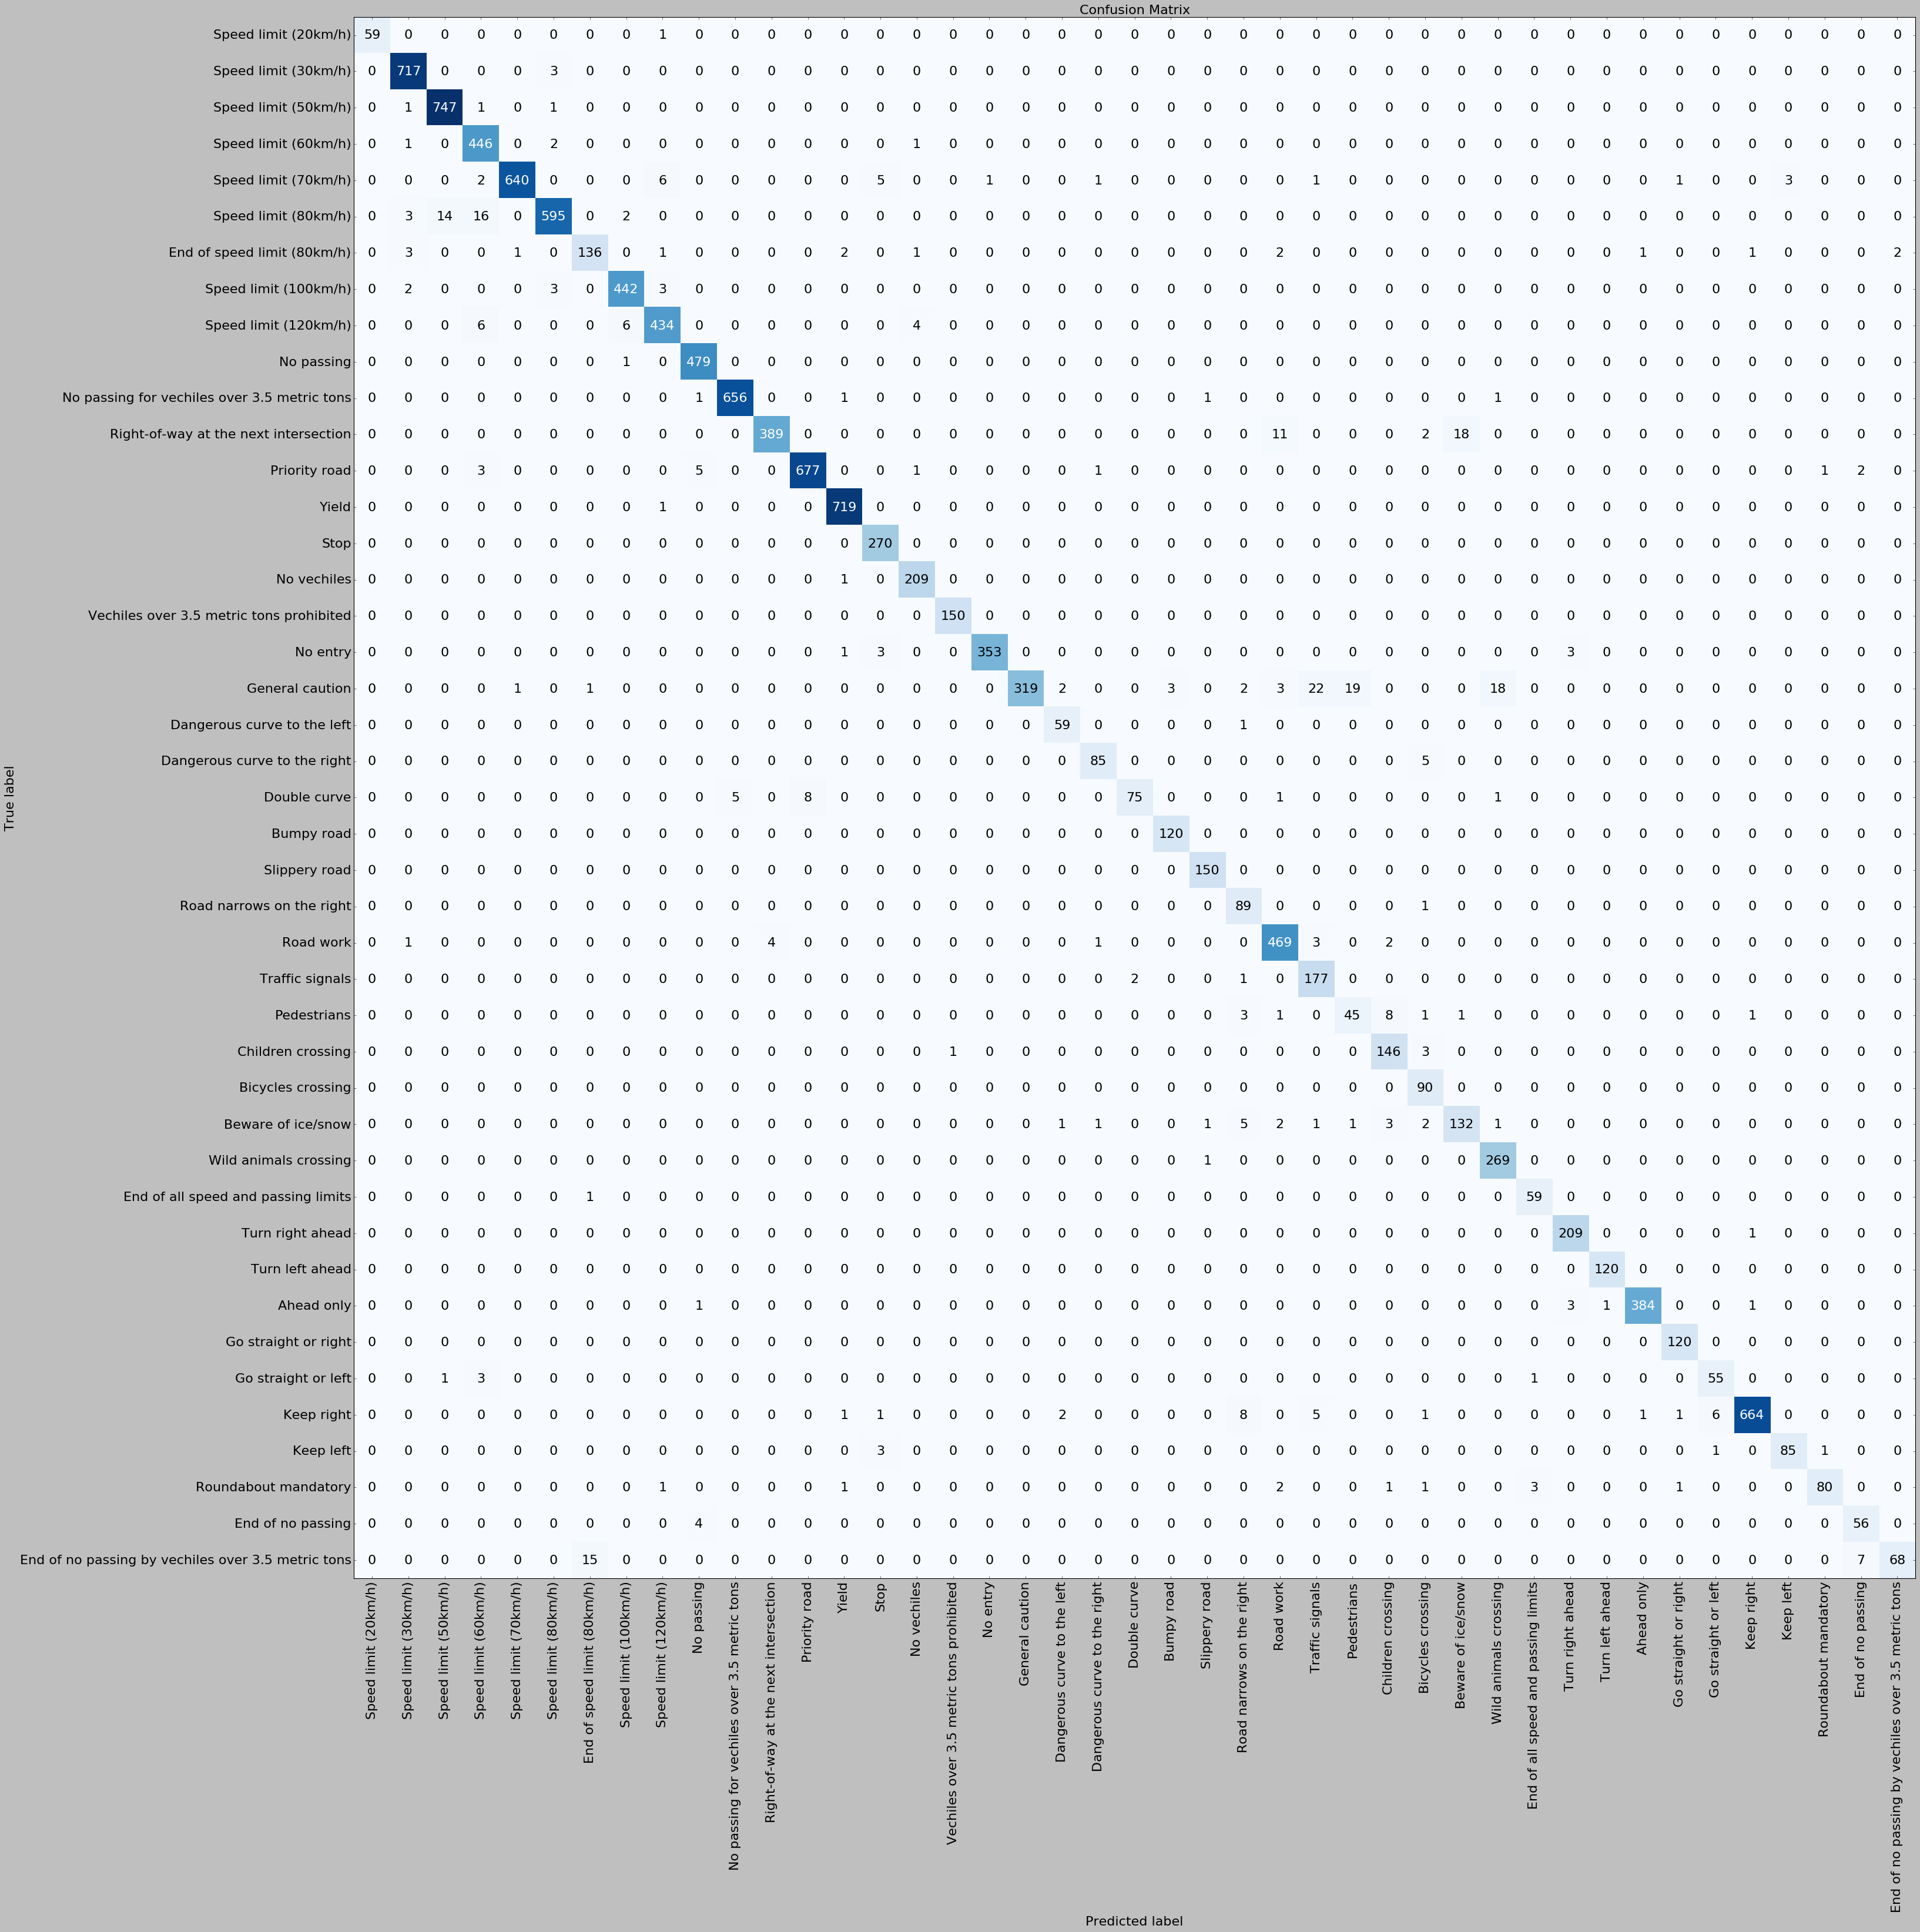

In [54]:
plt.style.use('classic')
plt.figure(figsize=(41,41))
pretty_print_conf_matrix(y_test, y_pr,data_np,
                         normalize=False, 
                         title='Confusion Matrix')

In [55]:
from sklearn.metrics import classification_report
print(classification_report(y_test_label, y_pred_label))


                                                    precision    recall  f1-score   support

                                        Ahead only       0.99      0.98      0.99       390
                                Beware of ice/snow       0.87      0.88      0.88       150
                                 Bicycles crossing       0.85      1.00      0.92        90
                                        Bumpy road       0.98      1.00      0.99       120
                                 Children crossing       0.91      0.97      0.94       150
                       Dangerous curve to the left       0.92      0.98      0.95        60
                      Dangerous curve to the right       0.96      0.94      0.95        90
                                      Double curve       0.97      0.83      0.90        90
               End of all speed and passing limits       0.94      0.98      0.96        60
                                 End of no passing       0.86      0.93      0.

In [0]:
#########################################

In [0]:
#After fine tuning model,we can see that we have avoided the problem of overfitting as validation loss is less than training loss, and our validation accuracy is more than training accuracy

TESTING THE MODEL WITH REAL IMAGES

In [0]:
from keras.models import load_model
model = load_model('trained_model_best.h5')

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import pickle
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pandas as pd
import random

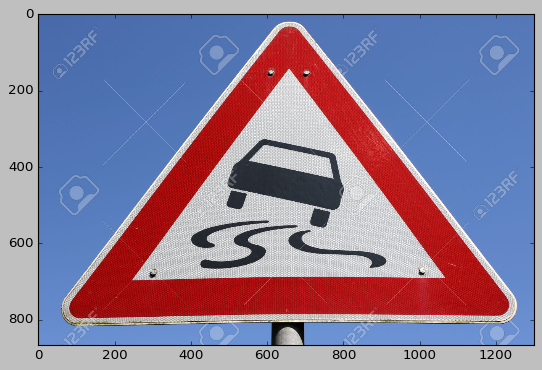

In [61]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
import requests
from PIL import Image

# 'https://upload.wikimedia.org/wikipedia/commons/4/43/Priority_road_sign_PW_03_R3_.png'
# 'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg'
# 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'
url = 'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

In [0]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def equalize(img):
    img = cv2.equalizeHist(img)
    return img#


In [0]:

def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255 #normalizing the input
    return img



(32, 32)


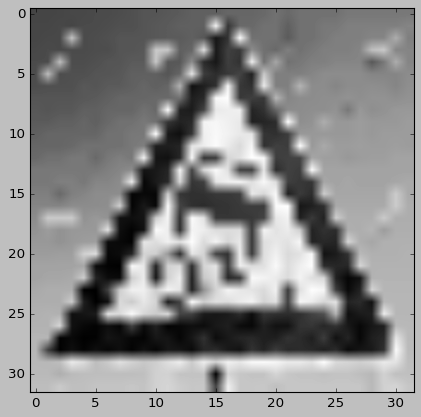

In [64]:
import cv2
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
 

In [69]:
img = img.reshape(1, 32, 32, 1)
import pyttsx3
engine = pyttsx3.init()
engine.say(data.iloc[model.predict_classes(img)[0]]['SignName'])
print("predicted sign index: "+ str(model.predict_classes(img)))
print("Predicted sign: " + data.iloc[model.predict_classes(img)[0]]['SignName'])
engine.runAndWait()

predicted sign index: [23]
Predicted sign: Slippery road


In [66]:
!pip install --upgrade pyttsx3

In [68]:
!apt-get -qq install -y espeak

Selecting previously unselected package libportaudio2:amd64.
(Reading database ... 130812 files and directories currently installed.)
Preparing to unpack .../libportaudio2_19.6.0-1_amd64.deb ...
Unpacking libportaudio2:amd64 (19.6.0-1) ...
Selecting previously unselected package libsonic0:amd64.
Preparing to unpack .../libsonic0_0.2.0-6_amd64.deb ...
Unpacking libsonic0:amd64 (0.2.0-6) ...
Selecting previously unselected package espeak-data:amd64.
Preparing to unpack .../espeak-data_1.48.04+dfsg-5_amd64.deb ...
Unpacking espeak-data:amd64 (1.48.04+dfsg-5) ...
Selecting previously unselected package libespeak1:amd64.
Preparing to unpack .../libespeak1_1.48.04+dfsg-5_amd64.deb ...
Unpacking libespeak1:amd64 (1.48.04+dfsg-5) ...
Selecting previously unselected package espeak.
Preparing to unpack .../espeak_1.48.04+dfsg-5_amd64.deb ...
Unpacking espeak (1.48.04+dfsg-5) ...
Setting up libportaudio2:amd64 (19.6.0-1) ...
Setting up espeak-data:amd64 (1.48.04+dfsg-5) ...
Setting up libsonic0:a